# NIFTY50 Index SIP Analysis

<font color='red'> Important Note! The stock data used in this study is obtained using free data source. As such the stock prices are not adjusted for stock splits and dividends. This will result in incorrect results. If adjusted closed prices are obtained, the same pipeline presented below can be used with correct data. </font>

## Imports

In [1]:
import numpy as np
import dask.dataframe as dd

import datetime
from datetime import date, timedelta
from dateutil.relativedelta import relativedelta

from nsepy import get_history

import seaborn as sns
import matplotlib.pyplot as plt

import os

import scipy.stats as stats

%matplotlib inline

In [2]:
from dask.distributed import Client
client = Client()
client

Client Scheduler: tcp://127.0.0.1:39367 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 8 Memory: 33.15 GB


In [3]:
import pandas as pd

In [23]:
start_date = pd.to_datetime('2002-01-08')
end_date = pd.to_datetime('2004-12-31')

#ending date for stock price fetching
#end_date = pd.to_datetime('2019-02-28')

In [24]:
months = int(np.floor(((end_date - start_date)/np.timedelta64(1, 'M'))))
months

35

In [25]:
stock_price_dataframe = pd.DataFrame()

In [26]:
stock_price_dataframe['ETF'] = get_history(symbol='NIFTYBEES', start=start_date, end=end_date)['Close']

In [27]:
stock_price_dataframe.head()

,ETF
Date,
2002-01-08,111.55
2002-01-09,109.15
2002-01-10,109.05
2002-01-11,108.10
2002-01-14,110.65


In [28]:
stock_price_dataframe.tail()

,ETF
Date,
2004-12-27,210.30
2004-12-28,208.50
2004-12-29,212.32
2004-12-30,210.25
2004-12-31,210.00


In [29]:
stock_price_dataframe.describe()

,ETF
count,753.000000
mean,135.881355
std,34.761951
min,93.750000
25%,106.100000
50%,116.750000
75%,166.900000
max,212.320000


In [30]:
stock_price_dataframe.to_csv("NIFTYBEES")

In [31]:
stock_price_dataframe_dd = dd.from_pandas(stock_price_dataframe, npartitions=len(stock_price_dataframe) / 100)

In [32]:
stock_price_dataframe_dd.head()

,ETF
Date,
2002-01-08,111.55
2002-01-09,109.15
2002-01-10,109.05
2002-01-11,108.10
2002-01-14,110.65


In [33]:
#stock_price_dataframe_dd.loc[start_date].values.compute()[0][0]

In [34]:
%%time
result = dd.from_pandas(pd.DataFrame(), npartitions=len(stock_price_dataframe) / 100)
total_invested = 0

for i in range(months+1):
#for i in range(3):
    # add a new month to the sip date
    next_sip_date = start_date + relativedelta(months=i)
    # print(next_sip_date)
    
    sip_size = 10000
    
    #calculate return of that sip
    portfolio_close_price_normalized = stock_price_dataframe_dd[next_sip_date : ].copy()
    portfolio_close_price_normalized['ETF'] = portfolio_close_price_normalized['ETF']/stock_price_dataframe_dd.loc[start_date].values.compute()[0][0]
    portfolio_close_price_normalized['ETF'] = portfolio_close_price_normalized['ETF'].apply(lambda normalized_return : normalized_return * sip_size, meta=('ETF', 'float64'))
    total_invested = total_invested + sip_size
    result = dd.merge(result,portfolio_close_price_normalized, how='outer', left_index=True, right_index=True)
    #print(f"Percent complete: {(i+1/months+1)*100}")


CPU times: user 4.4 s, sys: 199 ms, total: 4.6 s
Wall time: 4.58 s


In [35]:
result.npartitions

8

In [36]:
sum_result = result.sum(axis=1).compute()

In [37]:
sum_result = pd.DataFrame(sum_result, columns=['Value'])

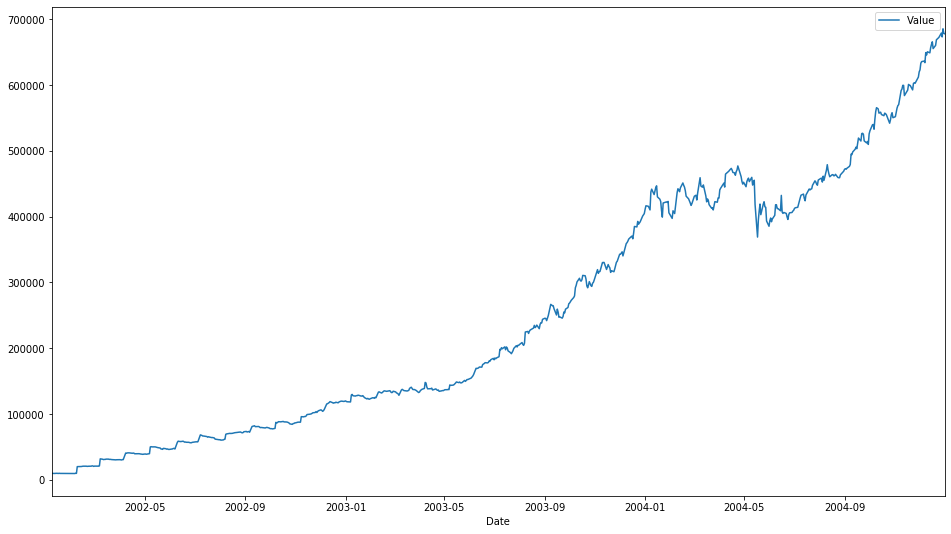

In [38]:
sum_result.plot(figsize=(16,9))

In [44]:
sum_result.iloc[-1][0]

678529.8072613181

In [40]:
total_invested

360000

In [43]:
f"Money grew by : {((sum_result.iloc[-1][0] - total_invested)/total_invested)*100}%"

'Money grew by : 88.4805020170328%'

## Disclaimer

GNU General Public License v3.0

THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS" AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDER OR CONTRIBUTORS BE LIABLE FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY, OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.